## This notebook will discuss another example of using a MCMC to do a fit. Originally I had thought maybe of using minimally spanning trees to glean more information, but then I thought better of it.

Consider the situation where we have a mixture of three generating processes:

$y(\vec{x}) \sim Af(\vec{x}) + Bg(\vec{x}) + C\delta(\vec{x})$

Where $\vec{x} = (x_1, x_2, ..., x_n)$, $A + B + C = 1$, and the multivariate PDFs $f$ and $g$ are normalised to 1. $\delta$ is a putative third process which might represent something we think is going on. Its existence would be indicated by $C$ being greter than 0 with high statistical significance.

How can we predict $A$, $B$, and $C$, given $y$, $f$, $g$, and a guess of $\delta$?

The standard answer would be something along the lines of:

- Do a binned maximum likelihood fit (in this case, I'll use a Bayesian MCMC model like in the other notebook), with and without the $\delta$ distribution.
- If the data aren't explained without $\delta$, and are explained with it, then it's increasing the model's predictive power. The fit that includes $\delta$ is the one to go with.
- If the data are explined just as well (within statistics) without $\delta$, cut the sucker off with Ockham's razor.
- If none of the models explain the data well enough, we can't say much.

This is good, but it assumes we *know* the functional form of $\delta$. What about cases where we're less certain about the theory (maybe we have a class of theories that can be reduced to a more-or-less constant distribution on one of the dimensions)? Apparently minimally spanning trees can help [see this paper](https://arxiv.org/pdf/1608.04772.pdf). 

But wait, that doesn't work for our problem as we define our trees using the Sobol points!

In [302]:
import numpy as np
import pymc
import matplotlib.pyplot as plt
import itertools
import os
%matplotlib inline

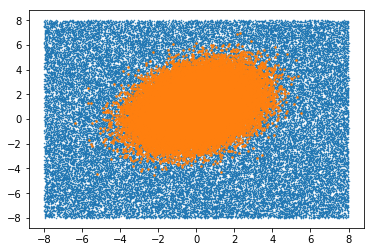

In [309]:
nsamples = 50000
#Let's make a 2D gaussian pdf as a sample:
mean = [0,1]
var = 2
corr = 0.3
cov = var*np.array([[1,corr],[corr,1]])
f_dist = np.random.multivariate_normal(mean, cov, nsamples)

#now let's make a uniform background
bglow = -8
bghigh = 8
g_dist = np.random.uniform(bglow, bghigh, size=(nsamples, 2))

plt.plot(g_dist[:,0], g_dist[:, 1], '.', markersize=1)
plt.plot(f_dist[:,0], f_dist[:, 1], '.', markersize=3)


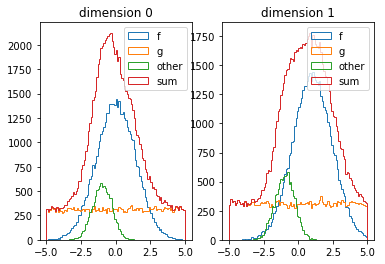

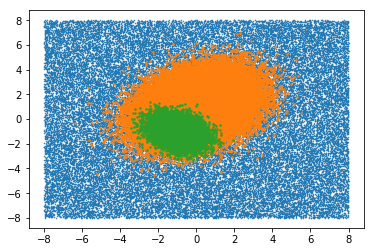

In [310]:
#Let's construct a 3rd process; a small (5 x smaller) second peak in the data at [-1,-1], with opposite correlation.
nother = 10000
#Let's make a 2D gaussian pdf as a sample:
mean_other = [-1,-1]
var_other = 0.5
corr_other = -0.3
cov_other = var_other*np.array([[1,corr_other],[corr_other,1]])
other = np.random.multivariate_normal(mean_other, cov_other, nother)

#Let's project onto the dimensions:
plt.subplot(1, 2, 1)
plt.hist(f_dist[:,0], bins=100, range=(-5,5), histtype='step', label='f')
plt.hist(g_dist[:,0], bins=100, range=(-5,5), histtype='step', label='g')
plt.hist(other[:,0], bins=100, range=(-5,5), histtype='step', label='other')
plt.hist(np.concatenate((f_dist,g_dist,other))[:,0], bins=100, range=(-5,5), histtype='step', label='sum')
plt.legend(loc='upper right')
plt.title('dimension 0')

#Let's project onto the dimensions:
plt.subplot(1, 2, 2)
plt.hist(f_dist[:,1], bins=100, range=(-5,5), histtype='step', label='f')
plt.hist(g_dist[:,1], bins=100, range=(-5,5), histtype='step', label='g')
plt.hist(other[:,1], bins=100, range=(-5,5), histtype='step', label='other')
plt.hist(np.concatenate((f_dist,g_dist,other))[:,1], bins=100, range=(-5,5), histtype='step', label='sum')
plt.legend(loc='upper right')
plt.title('dimension 1')

plt.figure()
plt.plot(g_dist[:,0], g_dist[:, 1], '.', markersize=1)
plt.plot(f_dist[:,0], f_dist[:, 1], '.', markersize=3)
plt.plot(other[:,0], other[:, 1], '.', markersize=3)


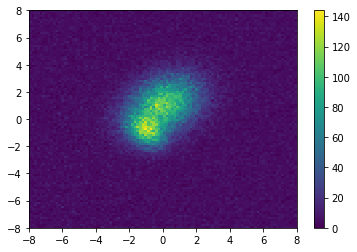

In [316]:
h1, xbins, ybins, img = plt.hist2d(np.concatenate((f_dist,g_dist,other))[:,0],np.concatenate((f_dist,g_dist,other))[:,1], bins=100, normed=False)
xbins = xedges[:-1] + (xedges[1]-xedges[0])
ybins = yedges[:-1] + (yedges[1]-yedges[0])
bincentres = np.array(zip(xcentres, ycentres))
plt.colorbar()
plt.show()

In [317]:
#Now that we have our data, let's generate a MCMC model to fit it...
#Note we need to normalise the data first.
H, xedges, yedges = np.histogram2d(np.concatenate((f_dist,g_dist,other))[:,0], 
                                   np.concatenate((f_dist,g_dist,other))[:,1],
                                   bins=100, range=[[-8,8],[-8,8]], normed=True)
xcentres = xedges[:-1] + (xedges[1]-xedges[0])
ycentres = yedges[:-1] + (yedges[1]-yedges[0])
#make the bin centres in 2-space.
bincentres = np.array(zip(xcentres, ycentres))
bincentres = np.array(np.meshgrid(xcentres, ycentres, indexing='xy')).T
print(np.shape(bincentres))

(100L, 100L, 2L)


In [321]:
### Let's define the model...
#first infer the number of dimensions from bincentres
ndim = np.shape(bincentres)[2]

## f-component.
# Define the variables needed for the routine, with their prior distributions
#Priors are assumed uniform:
f_mean = pymc.Container([pymc.Uniform('f_mean_0', -10, 10, value=2), 
                         pymc.Uniform('f_mean_1', -10, 10, value=-1)])
f_corr = pymc.Uniform('f_corr', -1, 1, value=0)
f_var = pymc.Uniform('f_var', 0, 10, value=1)
@pymc.deterministic
def f_cov(var=f_var, corr=f_corr):
    return var*np.array([[1,corr],[corr,1]])

@pymc.deterministic
def f_model(points=bincentres, mean=f_mean, cov=f_cov):
    """
    Return a normalised MV gaussian.
    """
    return np.array([np.power(2*np.pi, -(ndim/2))*np.power(np.linalg.det(cov), -0.5)*\
                     np.exp(-0.5*np.dot((points - mean).T[:,i,j],np.dot(np.linalg.inv(cov), 
                                                                        (points - mean).T[:, i, j])))
                     for i, j in itertools.product(range(np.shape(points)[0]), range(np.shape(points)[1]))]).\
                     reshape(np.shape(H))

#Sigma follows the same pattern, so in principle I could put this into a container, but I'm not game as pymc
#sometimes acts funny when you do that...
## sigma-component.
# Define the variables needed for the routine, with their prior distributions
#Priors are assumed uniform:
#Start this one closer to the sigma distribution so it converges to that.
sigma_mean = pymc.Container([pymc.Uniform('sigma_mean_0', -10, 10, value=0.5), 
                             pymc.Uniform('sigma_mean_1', -10, 10, value=-0.4)])
sigma_corr = pymc.Uniform('sigma_corr', -1, 1, value=0)
sigma_var = pymc.Uniform('sigma_var', 0, 10, value=1)
#sigma_cov = sigma_var.value*np.array([[1,sigma_corr.value],[sigma_corr.value,1]])
@pymc.deterministic
def sigma_cov(var=sigma_var, corr=sigma_corr):
    return var*np.array([[1,corr],[corr,1]])

@pymc.deterministic
def sigma_model(points=bincentres, mean=sigma_mean, cov=sigma_cov):
    """
    Return a normalised MV gaussian.
    """
    return np.array([np.power(2*np.pi, -(ndim/2))*np.power(np.linalg.det(cov), -0.5)*\
                     np.exp(-0.5*np.dot((points - mean).T[:,i,j],np.dot(np.linalg.inv(cov), 
                                                                        (points - mean).T[:, i, j])))
                     for i, j in itertools.product(range(np.shape(points)[0]), range(np.shape(points)[1]))]).\
                     reshape(np.shape(H))

#the probability of f:
p_f = pymc.Uniform('p_f', 0, 1, value=0.07)
#the probability of sigma:
p_sigma = pymc.Uniform('p_sigma', 0, 1, value=0.01)
## Now the BG model.
BG_level = pymc.Uniform('BG_level', 0, 1, value=0.005)

@pymc.deterministic
def y_model(p_f=p_f, p_sigma=p_sigma, BG_level=BG_level,
            f_model=f_model, sigma_model=sigma_model):
    return p_f*f_model + p_sigma*sigma_model + BG_level*np.ones(np.shape(H))

#Add some stochastic noise to the model value; the noise has some relationship to the total number of events
# and the binning. But I'm just going to treat it as another parameter.
# Note that this returns the likelihood
@pymc.stochastic(observed=False)
def U_y(value=0.1):
    return -np.log(abs(value))

y_meas = pymc.Normal('y', mu=y_model, tau=1. / U_y ** 2, observed=True, value=H)


# package the full model in a dictionary
CompoundModel = pymc.Model([y_meas, U_y, y_model, BG_level, p_sigma, p_f, 
                            sigma_model, sigma_cov, sigma_var, sigma_corr, sigma_mean,
                            f_model, f_cov, f_var, f_corr, f_mean])

C:\Users\lbignell\Documents\GitHub\cookbook-code\notebooks


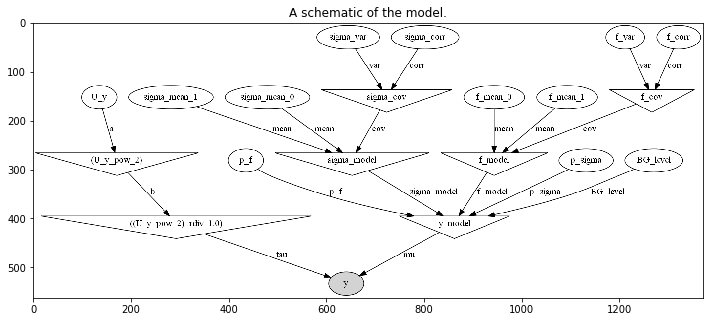

In [322]:
thegraph = pymc.graph.graph(CompoundModel, 
                            prog=r'C:\Program Files (x86)\Graphviz2.38\bin\dot.exe', format='png', path=r'.')
imdata = plt.imread('.\\container.png')
plt.figure(figsize=(12,500));
plt.imshow(imdata)
plt.title("A schematic of the model.")
print(os.path.abspath('.'))

In [323]:
mcmc = pymc.MCMC(CompoundModel)
mcmc.sample(iter=100, burn=20, thin=1)

 [-----------------101%-----------------] 101 of 100 complete in 651.7 sec

OK, that took way too long to run.
I should in principle optimise the run time.

Plotting f_var
Plotting sigma_corr
Plotting BG_level
Plotting f_mean_1
Plotting f_mean_0
Plotting f_cov_0_0
Plotting f_cov_0_1
Plotting f_cov_1_0
Plotting f_cov_1_1
Plotting p_f
Plotting sigma_mean_1
Plotting p_sigma
Plotting sigma_var
Plotting U_y
Plotting sigma_cov_0_0
Plotting sigma_cov_0_1
Plotting sigma_cov_1_0
Plotting sigma_cov_1_1
Plotting f_corr
Plotting sigma_mean_0


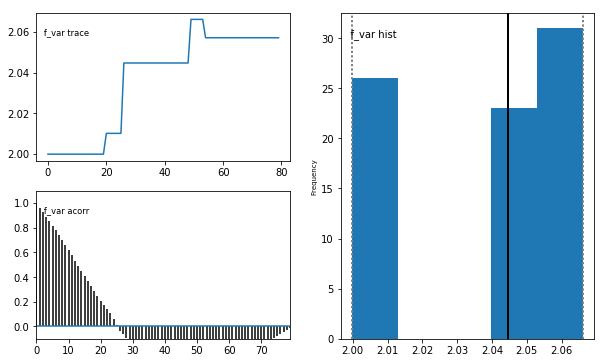

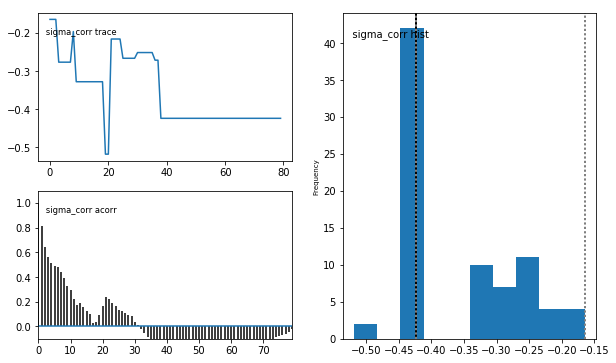

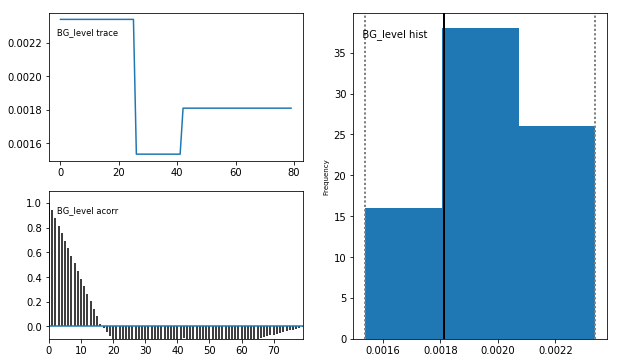

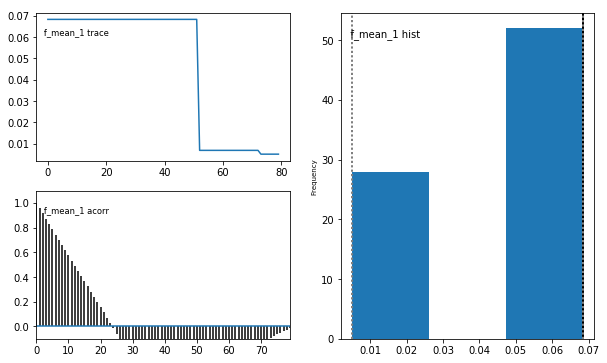

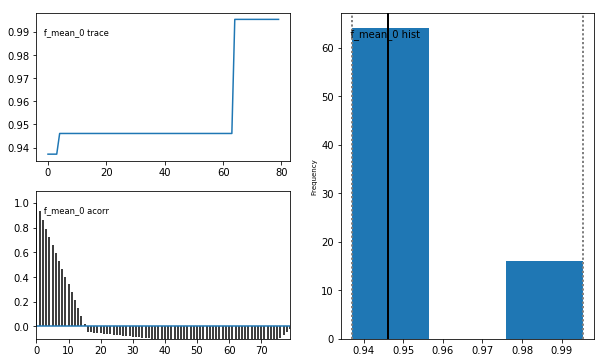

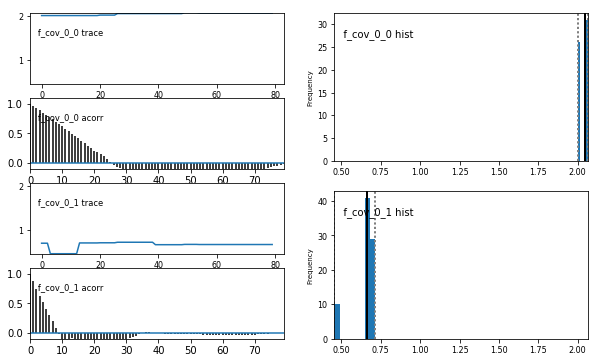

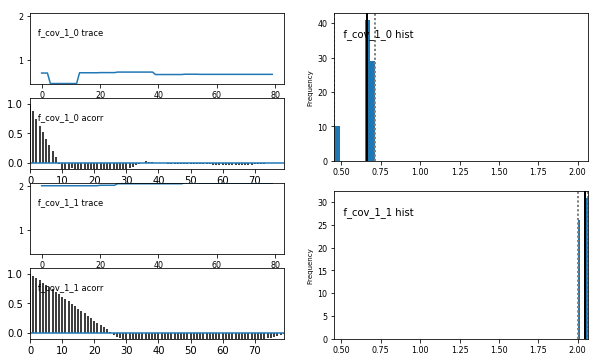

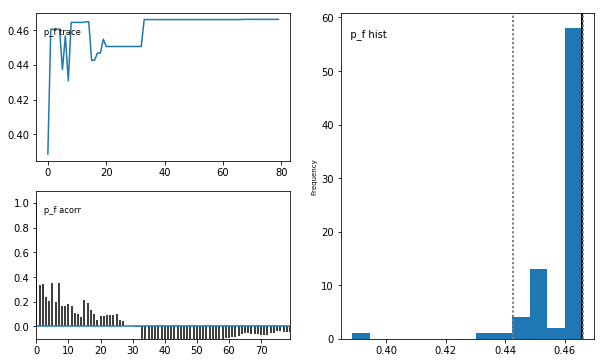

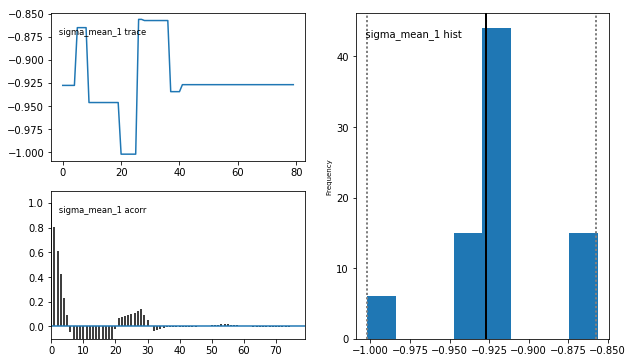

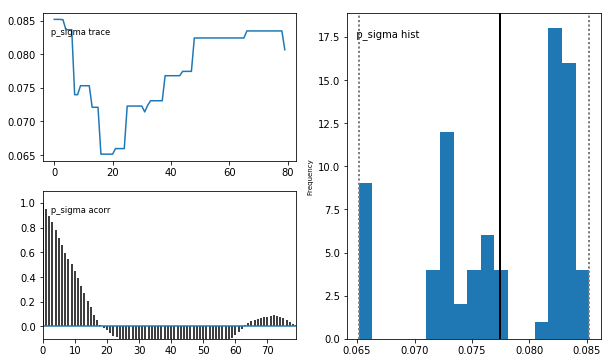

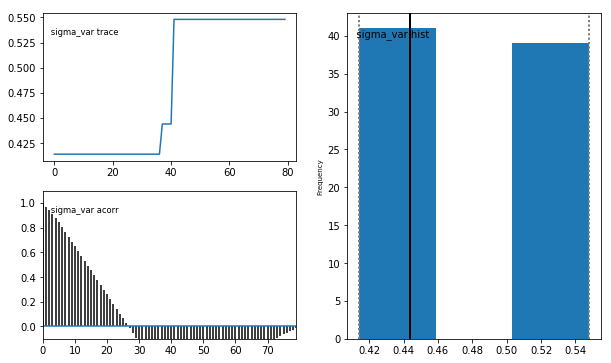

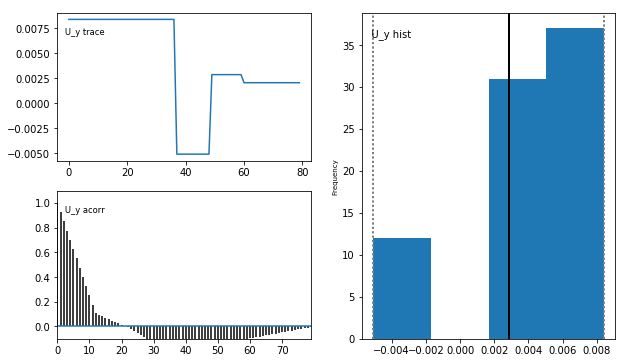

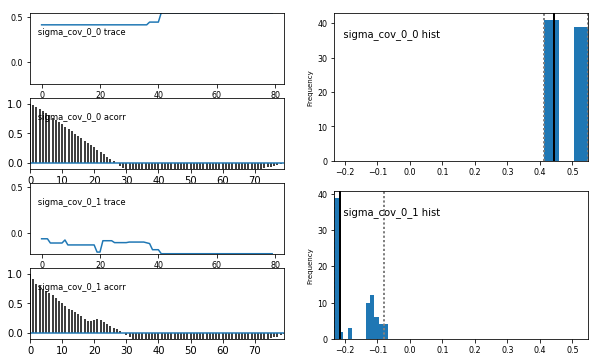

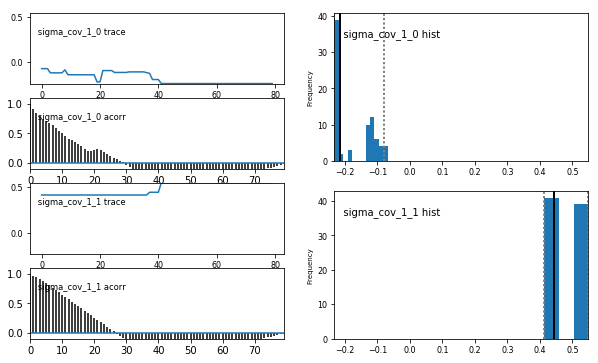

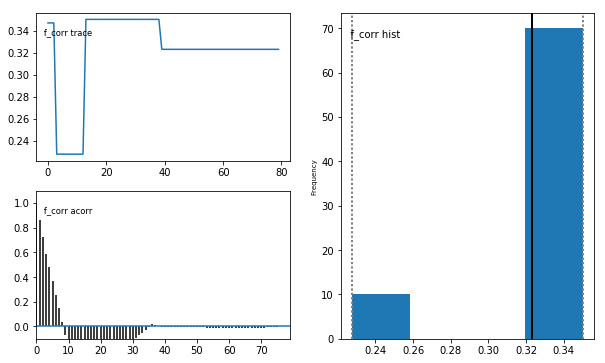

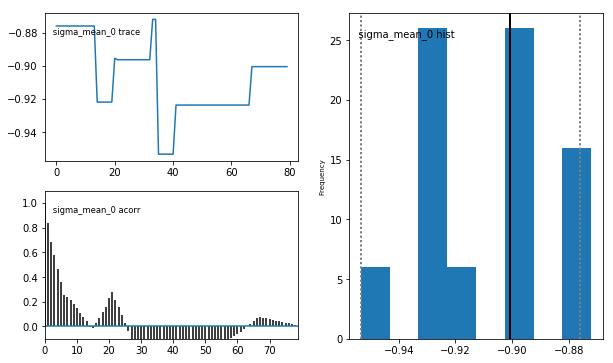

In [324]:
pymc.Matplot.plot(mcmc)

The convergence isn't perfect, but let's see how we go with what we've got.

In [451]:
np.mean(mcmc.trace('BG_level')[:])*100
#np.shape(np.sum(mcmc.trace('f_model')[:], axis=2))
#mcmc.variables
#vals = traces['p_f'][:, None, None]*traces['f_model'] + \
#            traces['p_sigma'][:, None, None]*traces['sigma_model'] + \
#            traces['BG_level'][:, None, None]


0.19277250947713898

In [446]:
# Create some convenience routines for plotting (same as other notebook, just modified for MV Gaussian)

def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, trace, keys=['f_mean_0', 'f_var'], scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[keys[0]], trace[keys[1]])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[keys[0]], trace[keys[1]], ',k', alpha=0.1)
    ax.set_xlabel(r'mean')
    ax.set_ylabel(r'$\sigma$')
    
def plot_MCMC_model(ax, xdata, ydata, trace, axis_idx=0):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata[axis_idx], np.sum(ydata, axis=axis_idx), 'ok')#/np.sum(ydata), 'ok')

    yfit = trace['p_f'][:, None]*np.sum(trace['f_model'], axis=axis_idx+1) + \
            trace['p_sigma'][:, None]*np.sum(trace['sigma_model'], axis=axis_idx+1) + \
            trace['BG_level'][:, None]*len(xdata[axis_idx]) #BG was defined per-bin
    mu = yfit.mean(0)#/np.sum(yfit.mean(0))
    sig = 2 * yfit.std(0)#/np.sum(yfit.mean(0))

    ax.plot(xdata[axis_idx], mu, '-k')
    ax.fill_between(xdata[axis_idx], mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')

def plot_MCMC_results(bincentres, Histdata, trace, colors='k', keys=['f_mean_0', 'f_var']):
    """
    Plot both the trace and the model together
    bincentres has [xcentres, ycentres]
    Trace is a dictionary containing all of the necessary traces for the calculation.
    """
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    plot_MCMC_trace(ax[0], trace, scatter=True, colors=colors, keys=keys)
    plot_MCMC_model(ax[1], bincentres, Histdata, trace, axis_idx=0)
    plot_MCMC_model(ax[2], bincentres, Histdata, trace, axis_idx=1)
    return ax


sig[0] = 0.0607706893022
sig[0] = 0.0607706241132


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000462FE780>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000393B7320>], dtype=object)

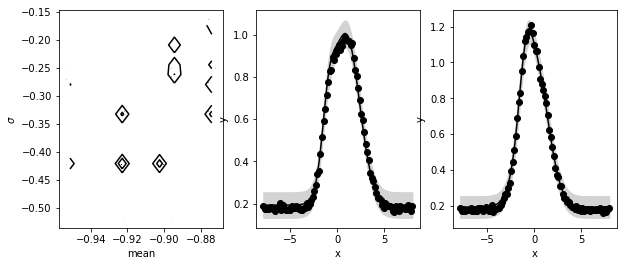

In [447]:
#Make list of traces:
traces = {str(item): mcmc.trace(str(item))[:] for item in mcmc.variables if 'y'!=str(item)}
yvals = H
xvals = [xcentres, ycentres]
plot_MCMC_results(xvals, yvals, traces, keys=['sigma_mean_0', 'sigma_corr'])


That looks pretty good!
Let's look at the means, std deviations, etc.

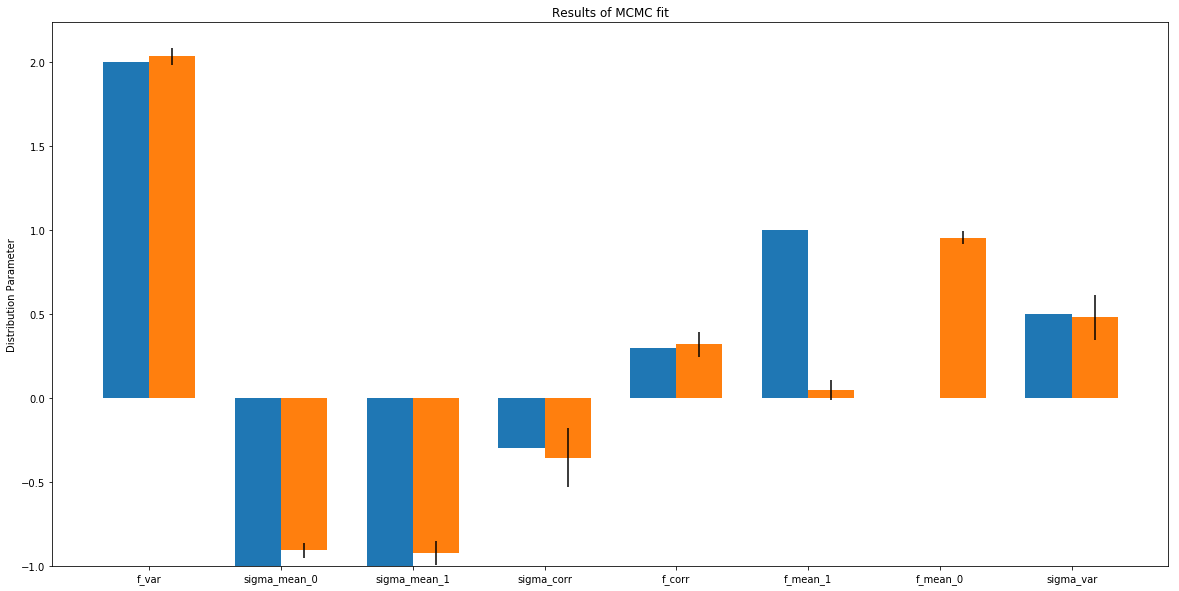

In [466]:
true_vals = {'f_mean_0': 0, 'f_mean_1': 1, 'f_var': 2, 'f_corr': 0.3, 
             'sigma_mean_0': -1, 'sigma_mean_1': -1, 'sigma_var': 0.5, 'sigma_corr': -0.3}
estimates = {key: np.mean(mcmc.trace(key)[:]) for key in true_vals.keys()}
Uestimates = {key: np.std(mcmc.trace(key)[:]) for key in true_vals.keys()}
ind = np.arange(len(true_vals))
width=0.35
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(ind, [true_vals[key] for key in true_vals.keys()], width, label='Expected')
ax.bar(ind+width, [estimates[key] for key in true_vals.keys()], width, 
        label='Fitted', yerr=[2*Uestimates[key] for key in true_vals.keys()])
ax.set_ylabel('Distribution Parameter')
ax.set_title('Results of MCMC fit')
ax.set_xticks(ind + width/2)
ax.set_xticklabels([key for key in true_vals.keys()])


Wow! That's pretty awesome. All except the means (and those are bloody hard) are within uncertainties! The labels of the f_mean values are swapped.